### Эксперименты с моделями глубокого обучения

Сначала хочу опучить модели с **RNN** и **LSTM** слоями. Т.к у нас входные данные атомарны (описания грамматических и пунктуационных вхожнений) в качестве токанайзера буду использовать unigram (BPE не подойдет - у нас "слова" не миксуются из слогов) 

In [1]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Dataset

from typing import Union, List, Tuple, Type, Optional, Any
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
import sentencepiece as spm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from tqdm.notebook import tqdm

from utils.utilsds import prepare_text

In [2]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
prepare_text(["мама мыла раму"], full=False)

['S,жен,од V,несов,пе S,жен,неод']

In [4]:
prepare_text(["мама мыла раму"], full=True)

['S,жен,од=им,ед V,несов,пе=прош,ед,изъяв,жен S,жен,неод=вин,ед']

In [5]:
# полный датасет
df = pd.read_csv('./data/splitted_df_3000.csv')

#X = df['text']
y = df['target'].map(lambda x: int(x[-2:]))

# датасат обработанный по полной схеме, с учетом падежей и тп
#X = pd.read_csv('./data/f_prepared_df_3000.csv')

# по сокращенной схеме
X = pd.read_csv('./data/b_prepared_df_3000.csv')

In [6]:
X['text']

0       A A S,жен,неод CM PR APRO A S,муж,неод PR APRO...
1       PR A S,сред,неод CL S,муж,од S,имя,муж,од CONJ...
2       CM CONJ APRO S,гео,муж,неод V,нп A CM A CONJ A...
3       V,несов,нп PR SPRO,мн PR S,муж,неод S,жен,неод...
4       V,сов,пе S,муж,неод CM A PR A ADV A S,сред,нео...
                              ...                        
2188    ADV PR S,муж,неод QST APRO S,мж,неод V,сов,нп ...
2189    SPRO,ед,3-л,муж V SPRO,ед,1-л APRO S,муж,неод ...
2190    PNT PART ADV SPRO,ед,1-л V,нп A SMC A V,нп CM ...
2191    PNT CONJ CONJ SPRO,ед,1-л ADV V,несов,нп PR S,...
2192    CONJ V,сов,нп S,муж,неод PNT PART CM V,несов,п...
Name: text, Length: 2193, dtype: object

In [7]:
# максимальное по длине предложение (слов)
max_len = 0
for text in X['text'].to_numpy():
    #print(text)
    if len(text.split()) > max_len:
        max_len = len(text.split())
        
print(max_len)        

651


In [8]:
# Создание словаря и преобразование меток
vocab = {word: idx + 1 for idx, word in enumerate(set(" ".join(X['text']).split()))}
vocab_size = len(vocab) + 1  # +1 для padding

num_classes = len(np.unique(y))
print(f"Число классов: {num_classes}, размер словаря {vocab_size}")

Число классов: 10, размер словаря 142


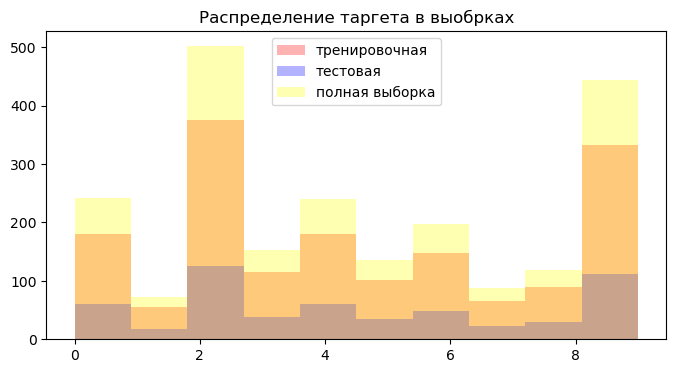

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

plt.figure(figsize=(8,4))
plt.title("Распределение таргета в выобрках")
plt.hist(y_train, bins=10, color='red', alpha=0.3, label='тренировочная')
plt.hist(y_test, bins=10, color='blue', alpha=0.3, label="тестовая")
plt.hist(y, bins=10, color='yellow', alpha=0.3, label='полная выборка')
plt.legend()
plt.show()

### Кодирование слов 

In [10]:
batch_size = 8

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len, pad_id = len(vocab)):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        self.pad_id  = pad_id 
        
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Преобразуем текст в последовательность индексов и добавляем паддинг
        text_indices = [self.vocab[word] if word in self.vocab else 0 for word in text.split()]
        text_indices = text_indices + [self.pad_id] * (self.max_len - len(text_indices))  # Padding
        label_idx = self.labels[idx]
        return torch.tensor(text_indices, dtype=torch.long), torch.tensor(label_idx, dtype=torch.long)

train_dataset = TextDataset(X_train['text'].to_numpy(), y_train.to_numpy(), vocab, max_len)
test_dataset = TextDataset(X_test['text'].to_numpy(), y_test.to_numpy(), vocab, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    
    

In [11]:
len(X_train['text'].to_numpy()), len(y_train.to_numpy()), 

(1644, 1644)

In [12]:
len(X_test['text'].to_numpy()), len(y_test.to_numpy()), 

(549, 549)

In [13]:
a = iter(test_loader)
print(next(a))

[tensor([[ 96,  29, 131,  ..., 141, 141, 141],
        [ 21, 130,  29,  ..., 141, 141, 141],
        [ 31,  56,  56,  ..., 141, 141, 141],
        ...,
        [ 29,  89, 130,  ..., 141, 141, 141],
        [ 89, 130,  56,  ..., 141, 141, 141],
        [131,  27,  84,  ..., 141, 141, 141]]), tensor([2, 6, 3, 2, 6, 2, 4, 7])]


In [14]:
#len(y_train), len(train_set)

In [15]:
#train_set.text2ids("A A S,жен,неод CM PR APRO A S,муж,неод PR")

In [16]:
#train_set.ids2text([13, 13, 6, 4, 16, 4, 7, 5, 11, 12, 15, 23, 13, 6, 4, 10, 4, 7, 5, 12, 15])

### Модель

In [17]:
class TextClassifier(nn.Module):
    def __init__(
        self,
        num_embeddings=10000,
        embedding_size=300,
        hidden_size=200,
        num_classes=10,
        num_layers=2,
        pad_id = len(vocab),
    ):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim=embedding_size, padding_idx=pad_id)
        self.lstm = nn.LSTM(embedding_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (last_hidden, last_c) = self.lstm(embedded)
        res = self.linear(last_hidden[-1]).squeeze()
        return res 


In [18]:
# Гиперпараметры
embed_size = 32
hidden_size = 128
num_epochs = 20
learning_rate = 0.05

model = TextClassifier(num_embeddings = vocab_size, embedding_size=embed_size, 
                       hidden_size=hidden_size, num_layers = 1,
    num_classes =num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
def plot_losses(train_losses: List[float], val_losses: List[float]):
    clear_output()
    plt.figure(figsize=(6, 6))
    plt.title("Кривая обучения")
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='val')
    plt.ylabel('loss')
    plt.ylabel('epoch')
    plt.show()


In [20]:
# для проверки что веса меняются
# model.state_dict().copy()["linear.weight"]

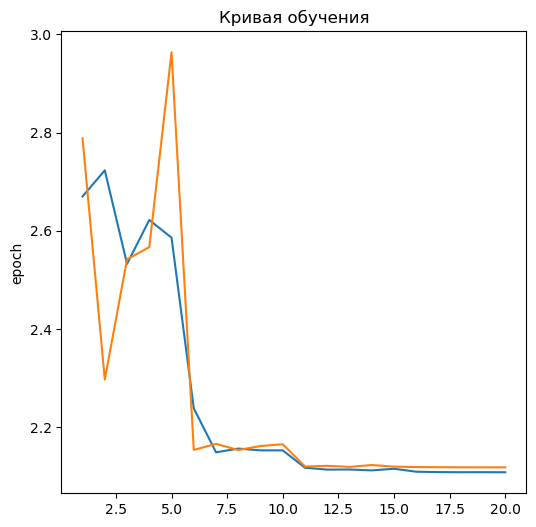

Epoch [20/20], Losses: 2.1083 / 2.1184 


In [21]:
@torch.no_grad()
def validation_epoch(model, 
                    criterion: nn.Module,
                    loader: DataLoader):

    device = next(model.parameters()).device
    val_loss = 0.0

    model.eval()
    val_loss = 0.0
    for texts, labels in loader:
        
        outputs = model.forward(texts.to(device))
        #print('texts:', texts)
        #print('logits:', outputs)
        loss = criterion(outputs, labels.to(device))
        val_loss += loss.item() * texts.size(0)

    val_loss /= len(loader.dataset)
    return val_loss

# Обучение модели
train_losses = [] 
val_losses = []
    
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for texts, labels in train_loader:

        optimizer.zero_grad()
        
        outputs = model(texts.to(device))
        #print('texts:', texts)
        #print('logits:', outputs)
        #print('labels:', labels)
        loss = criterion(outputs, labels.to(device))
        
        train_loss += loss.item() * texts.size(0) # домножаем на размер батча
        
        #loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        
        #model_parameters_new = model.state_dict()        
        #print(model_parameters_new["linear.bias"])
        
        # Печать градиентов слоев
        #for name, param in model.named_parameters():
        #    if param.grad is not None:
        #        print(f"Layer: {name} | Gradients: {param.grad}")
        #    else:
        #        print(f"Layer: {name} | No gradients")        
        
    scheduler.step()
    train_loss /= len(train_loader.dataset)
    
    train_losses.append(train_loss)    
    
    val_loss = validation_epoch(model, criterion, test_loader)
    val_losses.append(val_loss)
    plot_losses(train_losses, val_losses)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Losses: {train_loss:.4f} / {val_loss:.4f} ")


In [65]:
pad_id = len(vocab) 

@torch.inference_mode()
def inference(text: str, model) -> int:

    prep_text = prepare_text([text], full=False)
    #print(prep_text)
    
    text_indices = [vocab[word] if word in vocab else 0 for word in prep_text[0].split()]
    text_indices = text_indices + [pad_id] * (max_len - len(text_indices))  # Padding    
        
    #print(text_indices)
        
    model.eval()
    device = next(model.parameters()).device
    #print(f"device {device}")

    input_tensor = torch.tensor(text_indices).unsqueeze(0)  # (1, len(prefix)+1)
    #print("DIM:",input_tensor.dim())
    logits = model(input_tensor.to(device))
    #print(logits)    
    return np.argmax(logits)

In [66]:
inference("мама мыла раму, рама мыла маму", model)

tensor(2)

In [67]:
text = '''Бинарная классификация, многоклассовая классификация - для всех 
 этих алгоритмов встает одна и та же проблема: как оценить качество созданной модели? ... 
 Помимо precision и recall, при оценке моделей классификации часто используют и другие метрики.
 '''
inference(text, model)

tensor(2)

In [68]:
text = '''
Узкими горными тропинками, от одного дачного поселка до другого, пробиралась вдоль 
южного берега Крыма маленькая бродячая труппа. Впереди обыкновенно бежал, 
свесив набок длинный розовый язык, белый пудель Арто, остриженный наподобие льва. 
У перекрестков он останавливался и, махая хвостом, вопросительно оглядывался назад. 
По каким-то ему одному известным признакам он всегда безошибочно узнавал дорогу и, 
весело болтая мохнатыми ушами, кидался галопом вперед. За собакой шел двенадцатилетний 
мальчик Сергей, который держал под левым локтем свернутый ковер для акробатических упражнений, 
а в правой нес тесную и грязную клетку со щеглом, обученным вытаскивать из ящика разноцветные бумажки 
с предсказаниями на будущую жизнь. Наконец сзади плелся старший член труппы – дедушка Мартын Лодыжкин, 
с шарманкой на скрюченной спине.
'''
inference(text, model)

tensor(2)

In [69]:
text = '''
копать поздать. есть рыть пить. драть петь взять.
'''
a = inference(text, model)
int(a)

2

In [76]:
predicts = []
for text in df['text'][:200]:
    predicts.append(int(inference(text, model)))

In [77]:
from collections import Counter
Counter(predicts)


Counter({2: 154, 9: 46})

In [88]:
device = next(model.parameters()).device

preds = []

model.eval()
for texts, labels in test_loader:
        
    logits = model.forward(texts.to(device))
    preds.extend(list(torch.argmax(logits, dim=1).numpy()))


In [93]:
f1_score(y_test, preds, average='weighted')

0.14642600408771214